In [193]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from sklearn import metrics
from sklearn import preprocessing
from sklearn import  linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tools.tools import add_constant
from statsmodels.stats.diagnostic import het_breuschpagan,acorr_breusch_godfrey
from statsmodels.compat import lzip
import csv
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sn
import statistics
from scipy import stats
import numpy.linalg
from scipy.stats import spearmanr,pearsonr, kstest,shapiro, anderson, normaltest
import math

data.csv includes lastest edition FIFA 2019 players attributes like Age, Nationality, Overall, Club,              
Wage, Preferred_Foot, Position, Height, Weight, ShortPassing, FKAccuracy, LongPassing, BallControl, Acceleration, SprintSpeed, Agility, Reactions, Balance, ShotPower, Jumping, Stamina, Strength, LongShots, Positioning, Penalties.  

Данные включают в себя последние издания FIFA 2019 игроков атрибуты, такие как Возраст, Национальность, Общий, Клуб, Заработная плата, Предпочтительная нога, Положение, Рост, Вес, Шортпассинг, Точность FK,Long Passing, Контроль мяча, Ускорение, Скорость спринта, Ловкость,Реакции, баланс, сила удара, прыжки, выносливость, сила,Длинные выстрелы, Позиционирование, Пенальти

In [2]:
master_data=pd.read_csv('data.csv')
master_data.head()
master_data.drop(columns = ['Unnamed: 0','Name','ID','WorkRate','BodyType','RealFace','LoanedFrom','Value','InternationalReputation','Joined','WeakFoot','GKDiving', 'GKHandling','GKKicking', 'GKPositioning','Aggression','Vision','Vision','Special', 'SkillMoves','Volleys', 'Dribbling', 'Curve','Interceptions', 'HeadingAccuracy','Crossing', 'Potential','Finishing', 'GKReflexes', 'ReleaseClause','ContractValidUntil','JerseyNumber','Flag','ClubLogo','LS','ST','RS','LW','LF','CF','RF','RW','LAM','CAM','RAM','LM','LCM','CM','RCM','RM','LWB','LDM','CDM','RDM','RWB','LB','LCB','CB','RCB','RB','Photo','Composure', 'Marking', 'StandingTackle', 'SlidingTackle'], inplace=True)
master_data.columns.str.strip()
master_data.rename(columns = {'PreferredFoot':'Preferred_Foot'                              
                             }, inplace = True)
master_data.fillna(master_data.mean(), inplace=True)


In [3]:
master_data.columns
columnsTitles=['Overall','Age', 'Nationality', 'Club', 'Wage', 'Preferred_Foot',
       'Position', 'Height', 'Weight', 'ShortPassing', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Positioning', 'Penalties']
master_data=master_data.reindex(columns=columnsTitles)


Подготовка данных, убираем NaN значения - заменяем на среднее значение, переводим единицы измерения к русским и обрабатываем категориальные признаки

In [4]:
master_data['Wage'] = master_data.Wage.str.replace('€','')
master_data['Wage'] = master_data.Wage.str.replace('K','000')
master_data['Wage'] = master_data.Wage.astype('int64')
master_data['Weight'] = master_data.Weight.str.replace('lbs','').astype('float64')
master_data['Height'] = master_data.Height.str.replace('\'','.').astype('float64')
master_data.fillna(0, inplace=True)
master_data['Preferred_Foot'] = master_data.Preferred_Foot.astype('category')
master_data['Nationality'] = master_data.Nationality.astype('category')
master_data['Club'] = master_data.Club.astype('category')
master_data['Position'] = master_data.Position.astype('category')
master_data['Weight'] = master_data.Weight*0.454
master_data['Height'] = master_data.Height*30

In [5]:
master_data.head().T

,0,1,2,3,4
Overall,94,94,92,91,91
Age,31,33,26,27,27
Nationality,Argentina,Portugal,Brazil,Spain,Belgium
Club,FCBarcelona,Juventus,ParisSaint-Germain,ManchesterUnited,ManchesterCity
Wage,565000,405000,290000,260000,355000
Preferred_Foot,Left,Right,Right,Right,Right
Position,RF,ST,LW,GK,RCM
Height,171,186,177,192,153.3
Weight,72.186,83.082,68.1,76.272,69.916
ShortPassing,90,81,84,50,92


Для данного массива проведем статистический анализ каждой переменной, вычислив ее выборочные числовые характеристики: среднее, дисперсию, моду, медиану, эксцесс, асимметрию, коэффициент вариации, размах.

In [6]:
cols = ['Mean', 'Mode', 'Median', 'Variance', 'Skew', 'Kurtosis', 'Range', 'Std', 'k variation']
temp= []
dt_stat = pd.DataFrame(columns=cols)
pre_dt = 0
for name, values in master_data.iteritems():
    if (master_data[name].dtype.name != 'category'):
#         temp.append(name)
        temp.append(statistics.mean(master_data[name]))
        temp.append(statistics.mode(master_data[name]))
        temp.append(statistics.median(master_data[name]))
        temp.append(statistics.variance(master_data[name]))
        temp.append(stats.skew(master_data[name]))
        temp.append(stats.kurtosis(master_data[name]))
        temp.append(np.max(master_data[name])-np.min(master_data[name]))
        temp.append(np.std(master_data[name]))
        temp.append(np.std(master_data[name])/statistics.mean(master_data[name])*100)  
        dt_stat.loc[name] = temp
        temp=[]
        pre_dt = pre_dt+1
print(dt_stat)
        

                     Mean     Mode   Median      Variance      Skew  \
Overall         66.238699    66.00    66.00  4.773331e+01  0.067179   
Age             25.122206    21.00    25.00  2.180836e+01  0.391732   
Wage          9731.312133  1000.00  3000.00  4.839688e+08  7.905368   
Height         173.462498   180.00   177.00  2.598840e+02 -3.541539   
Weight          75.155864    74.91    74.91  6.491681e+01 -1.936397   
ShortPassing    58.686712    64.00    62.00  2.155055e+02 -1.101678   
FKAccuracy      42.863153    42.00    41.00  3.047017e+02  0.102244   
LongPassing     52.711933    62.00    56.00  2.343242e+02 -0.596378   
BallControl     58.369459    65.00    63.00  2.777084e+02 -1.269433   
Acceleration    64.614076    69.00    67.00  2.222511e+02 -0.816311   
SprintSpeed     64.726967    68.00    67.00  2.140553e+02 -0.829612   
Agility         63.503607    68.00    66.00  2.174614e+02 -0.600158   
Reactions       61.836610    65.00    62.00  8.097442e+01 -0.114268   
Balanc

Визуализация разброса каждого фактора

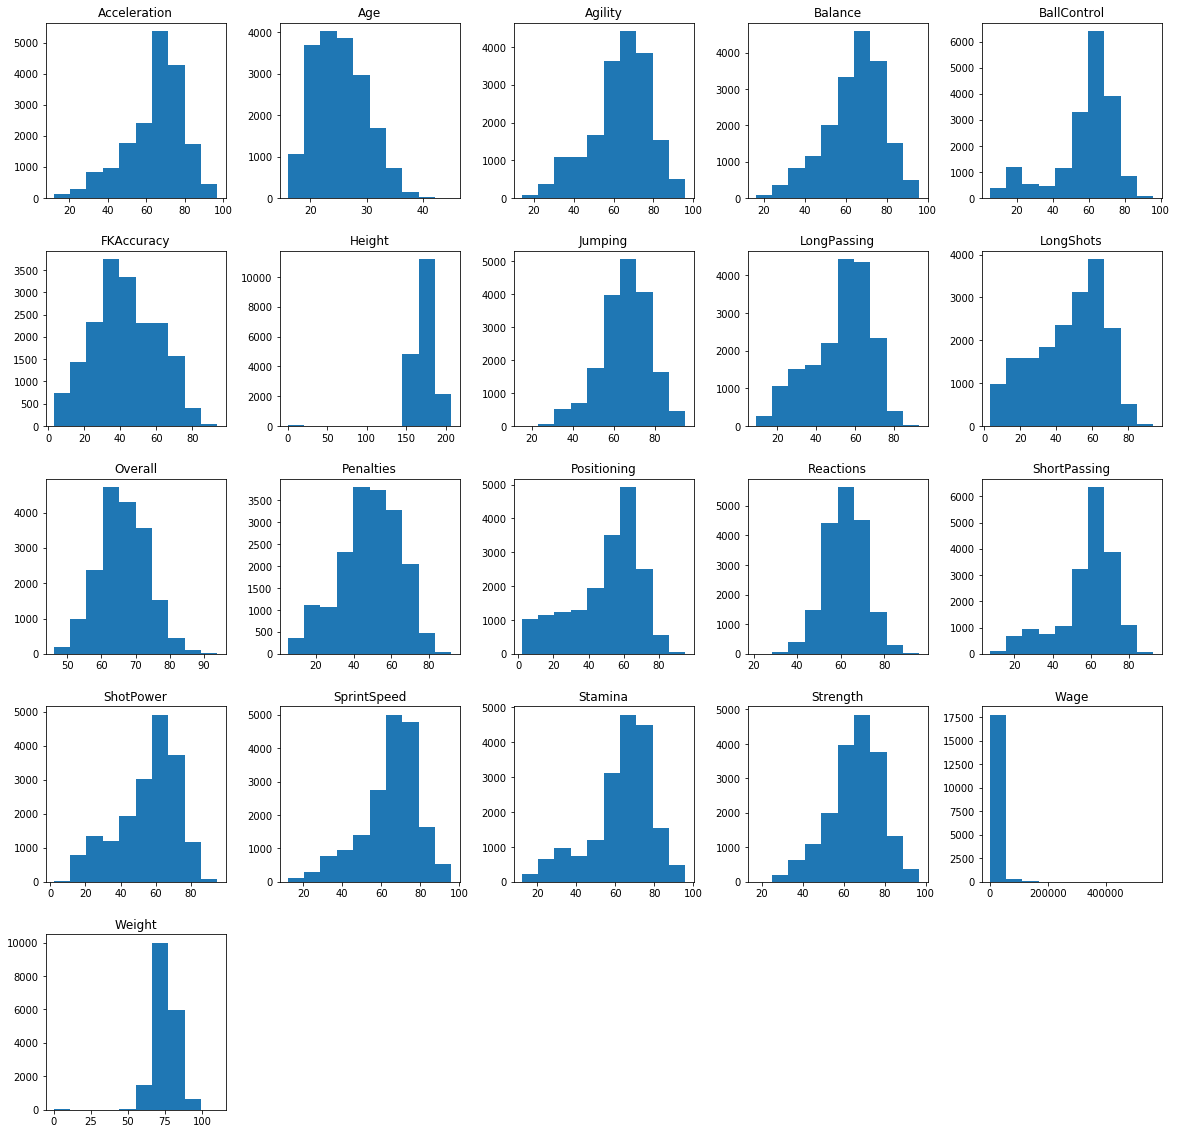

In [7]:
histohrams = master_data.hist(grid=False, figsize=(20, 20))

Построим корреляционную матрицу для вычисления тесноты связей между зависимой переменной и каждым фактором

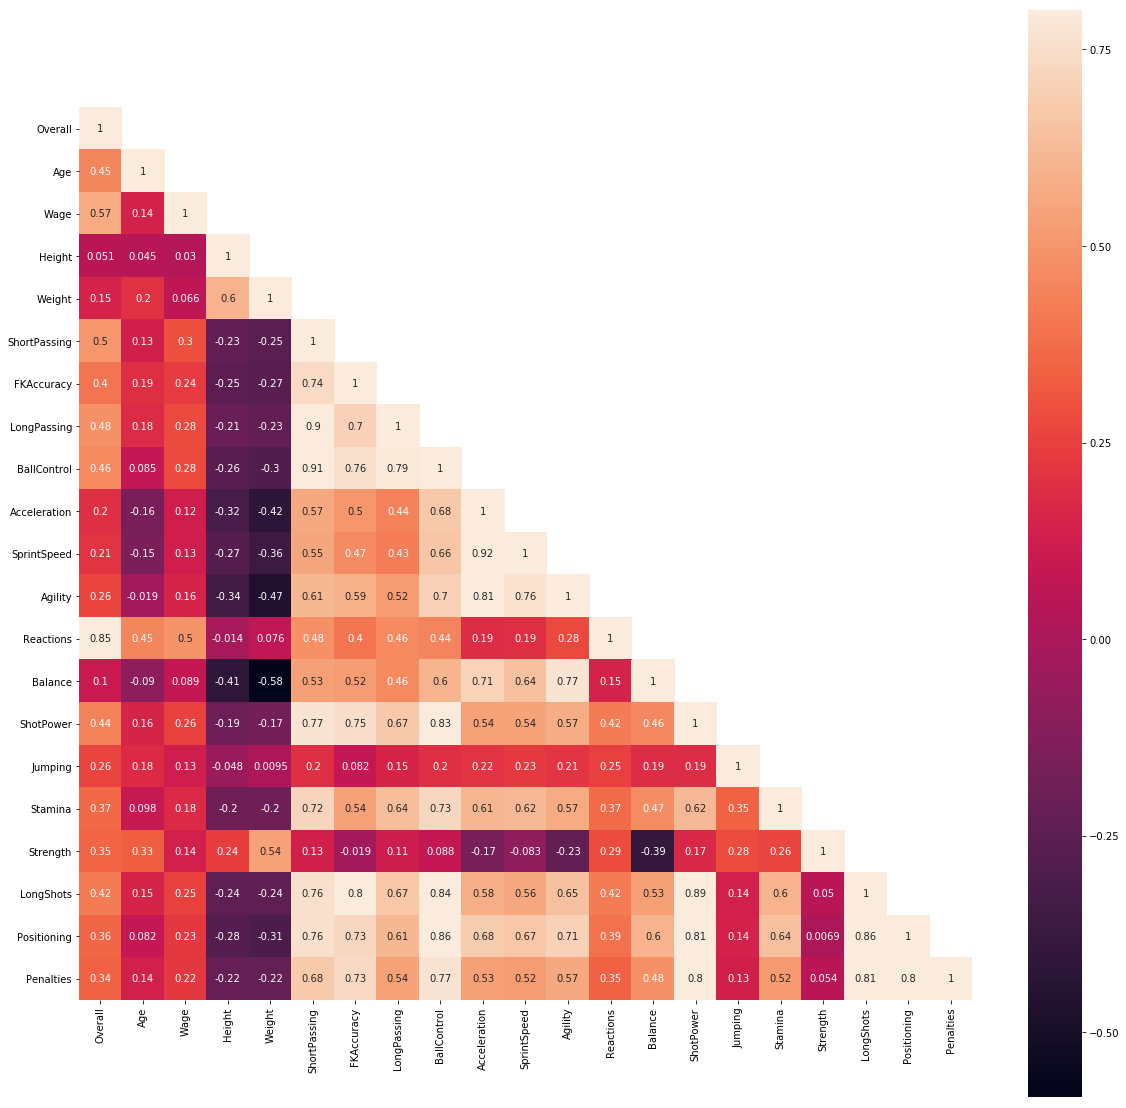

In [8]:
corr = master_data.corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig,ax = plt.subplots()
fig.set_size_inches(20,20)
sn.heatmap(corr, mask=mask, vmax=.8, square=True, annot = True)

Построим уравнение множественной линейной регрессии, включив в модель все имеющиеся факторы.

In [29]:
X = master_data.drop(['Overall',
                     'Nationality',
                      'Club',
                      'Preferred_Foot',
                      'Position'], axis=1)
Y = master_data['Overall']
X_train = X
Y_train = Y

Коэффициенты регрессии

In [21]:
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train, Y_train)
cdf = pd.DataFrame(lin_reg.coef_,X.columns, columns=['Coefficients'])
print(cdf)
print("Independent term in the model "+ str(lin_reg.intercept_))

              Coefficients
Age               0.160905
Wage              0.000060
Height            0.013617
Weight            0.050484
ShortPassing      0.036267
FKAccuracy        0.003393
LongPassing       0.014551
BallControl       0.054452
Acceleration      0.026180
SprintSpeed       0.020977
Agility           0.027594
Reactions         0.469966
Balance          -0.040019
ShotPower         0.018255
Jumping           0.014246
Stamina          -0.028274
Strength          0.025081
LongShots         0.013198
Positioning      -0.057823
Penalties        -0.017471
Independent term in the model 19.261046852901103


Найдем коэффициент детерминации и скорректированный коэффициент детерминации

In [23]:
#R^2 (coefficient of determination) regression score function.
r2 = r2_score(Y_test, Y_pred)
print('r2 score: ',r2)
r2_adj = 1-((1-r2*r2)*(Y_pred.size-1)/(Y_pred.size-1-len(X_test.columns)))
print('r2_adj:', r2_adj)

r2 score:  0.8043459867974945
r2_adj: 0.646000206676842


In [24]:
alfa = 0.05
n = Y_pred.size-1-len(X_test.columns)
t = stats.t(n)
tcr = t.ppf(1-alfa/2)
F = (r2/(1-r2))*((Y_pred.size-len(X_test.columns)-1)/len(X_test.columns))
print("F :", F )
print ("t-stat_cr ", tcr)
print ("queue_mean", np.mean(Y_pred))
print ("queue_di", tcr*np.std(Y_pred)/np.sqrt(Y_pred.size))

F : 1492.7269981622346
t-stat_cr  1.9602907071984967
queue_mean 66.33429930195652
queue_di 0.14232099206666307


МНК

In [25]:
X2 = sm.add_constant(X_train)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
# print(est2.summary())

Проверим коэффициенты на значимость по критерию Стьюдента.

In [26]:
abs(est2.tvalues) > tcr

const            True
Age              True
Wage             True
Height           True
Weight           True
ShortPassing     True
FKAccuracy      False
LongPassing      True
BallControl      True
Acceleration     True
SprintSpeed      True
Agility          True
Reactions        True
Balance          True
ShotPower        True
Jumping          True
Stamina          True
Strength         True
LongShots        True
Positioning      True
Penalties        True
dtype: bool

Незначимы: FKAccuracy

In [53]:
Xm = sm.add_constant(X_train)
temp = Xm.values
# print(np.matrix(Xm))
print("det(X.T*X)",np.linalg.det((np.matrix(Xm.values).T*np.matrix(Xm.values))))

det(X.T*X) 5.907863821741096e+132


In [27]:
X3 = add_constant(X2)
pd.Series([vif(X3.values, i) 
               for i in range(X3.shape[1])], 
              index=X3.columns)

const           362.891016
Age               1.571055
Wage              1.369447
Height            1.612568
Weight            2.514562
ShortPassing     12.078430
FKAccuracy        3.750689
LongPassing       6.106675
BallControl      12.129028
Acceleration      8.826860
SprintSpeed       7.305655
Agility           4.527403
Reactions         2.073354
Balance           3.565247
ShotPower         6.246620
Jumping           1.363366
Stamina           3.048650
Strength          2.614339
LongShots         7.845311
Positioning       6.528464
Penalties         3.921525
dtype: float64

Получается так. Часто используют границу 5 или 10, если показатель VIF больше данного значения - есть линейная зависимость от остальных переменных

Если VIF (Variance Inflation Factor) возле каждой независимой переменной меньше 10 — значит, эффекта мультиколлинеарности не наблюдается и регрессионная модель приемлема для дальнейшей интерпретации. Чем выше показатель VIF, тем более связаны между собой переменные

методом включения факторов в модель на основе прироста скорректированного коэффициента детерминации построим уравнение множественной регрессии

In [55]:
for i in X_train.columns:
    col = [i]
    XX = X_train[col]
    X2 = sm.add_constant(XX)
    est = sm.OLS(Y_train, X2)
    est2 = est.fit()
    print('factor :',i,'r2_adj:',est2.rsquared_adj)

factor : Age r2_adj: 0.20830325615566603
factor : Wage r2_adj: 0.33868081849514187
factor : Height r2_adj: 0.0033836927037317333
factor : Weight r2_adj: 0.021295338251862694
factor : ShortPassing r2_adj: 0.24384010297469116
factor : FKAccuracy r2_adj: 0.1516649312888282
factor : LongPassing r2_adj: 0.2278164923775684
factor : BallControl r2_adj: 0.2048697430448898
factor : Acceleration r2_adj: 0.036422286119139
factor : SprintSpeed r2_adj: 0.04186256654110987
factor : Agility r2_adj: 0.06919733360871139
factor : Reactions r2_adj: 0.726639890104543
factor : Balance r2_adj: 0.010303421090792408
factor : ShotPower r2_adj: 0.18520808088819352
factor : Jumping r2_adj: 0.07012177147846665
factor : Stamina r2_adj: 0.1290286028402413
factor : Strength r2_adj: 0.11793713914003179
factor : LongShots r2_adj: 0.1687144663803476
factor : Positioning r2_adj: 0.12157330392380994
factor : Penalties r2_adj: 0.10993666683842973


Reactions r2_adj: 0.726639890104543 - max r2_adj

In [56]:
col=['Reactions']
for i in X_train.columns:
    if i!='Reactions':
        col.append(i)
        XX = X_train[col]
        X2 = sm.add_constant(XX)
        est = sm.OLS(Y_train, X2)
        est2 = est.fit()
        print('factors', col,'r2_adj:',est2.rsquared_adj)
        col=['Reactions']

factors ['Reactions', 'Age'] r2_adj: 0.7328316537816122
factors ['Reactions', 'Wage'] r2_adj: 0.7581540521522591
factors ['Reactions', 'Height'] r2_adj: 0.7308092539301663
factors ['Reactions', 'Weight'] r2_adj: 0.7346762487320928
factors ['Reactions', 'ShortPassing'] r2_adj: 0.7360459224109221
factors ['Reactions', 'FKAccuracy'] r2_adj: 0.7299876047292704
factors ['Reactions', 'LongPassing'] r2_adj: 0.7363236803210433
factors ['Reactions', 'BallControl'] r2_adj: 0.733536559663309
factors ['Reactions', 'Acceleration'] r2_adj: 0.7276225578452655
factors ['Reactions', 'SprintSpeed'] r2_adj: 0.7284318258388471
factors ['Reactions', 'Agility'] r2_adj: 0.7275014536756486
factors ['Reactions', 'Balance'] r2_adj: 0.7274499839311395
factors ['Reactions', 'ShotPower'] r2_adj: 0.7339433582747741
factors ['Reactions', 'Jumping'] r2_adj: 0.728883431858128
factors ['Reactions', 'Stamina'] r2_adj: 0.7293362173156361
factors ['Reactions', 'Strength'] r2_adj: 0.7386865653517145
factors ['Reactions', '

factors ['Reactions', 'Wage'] r2_adj:  0.7581540521522591- max 

In [57]:
col=['Reactions','Wage']
for i in X_train.columns:
    if ((i!='Reactions')or(i!='Wage')):
        col.append(i)
        XX = X_train[col]
        X2 = sm.add_constant(XX)
        est = sm.OLS(Y_train, X2)
        est2 = est.fit()
        print('factors', col,'r2_adj:',est2.rsquared_adj)
        col=['Reactions','Wage']

factors ['Reactions', 'Wage', 'Age'] r2_adj: 0.7676399836338758
factors ['Reactions', 'Wage', 'Wage'] r2_adj: 0.7581540521522592
factors ['Reactions', 'Wage', 'Height'] r2_adj: 0.7613979612179387
factors ['Reactions', 'Wage', 'Weight'] r2_adj: 0.7652038269161549
factors ['Reactions', 'Wage', 'ShortPassing'] r2_adj: 0.7650356010741899
factors ['Reactions', 'Wage', 'FKAccuracy'] r2_adj: 0.7605783304376642
factors ['Reactions', 'Wage', 'LongPassing'] r2_adj: 0.7656517207511824
factors ['Reactions', 'Wage', 'BallControl'] r2_adj: 0.7629623125423365
factors ['Reactions', 'Wage', 'Acceleration'] r2_adj: 0.7587998359682475
factors ['Reactions', 'Wage', 'SprintSpeed'] r2_adj: 0.7594117737944179
factors ['Reactions', 'Wage', 'Agility'] r2_adj: 0.758782877830087
factors ['Reactions', 'Wage', 'Reactions'] r2_adj: 0.7581540521522591
factors ['Reactions', 'Wage', 'Balance'] r2_adj: 0.7591326873871836
factors ['Reactions', 'Wage', 'ShotPower'] r2_adj: 0.7637037522986037
factors ['Reactions', 'Wage',

factors ['Reactions', 'Wage', 'Strength'] r2_adj: 0.7701948639268916 - max

In [58]:
col=['Reactions','Wage','Strength']
for i in X_train.columns:
    if ((i!='Reactions')or(i!='Wage')or(i!='Strength')):
        col.append(i)
        XX = X_train[col]
        X2 = sm.add_constant(XX)
        est = sm.OLS(Y_train, X2)
        est2 = est.fit()
        print('factors', col,'r2_adj:',est2.rsquared_adj)
        col=['Reactions','Wage','Strength']

factors ['Reactions', 'Wage', 'Strength', 'Age'] r2_adj: 0.7755635158810646
factors ['Reactions', 'Wage', 'Strength', 'Wage'] r2_adj: 0.7701948639268916
factors ['Reactions', 'Wage', 'Strength', 'Height'] r2_adj: 0.7710914130018678
factors ['Reactions', 'Wage', 'Strength', 'Weight'] r2_adj: 0.7710483683302923
factors ['Reactions', 'Wage', 'Strength', 'ShortPassing'] r2_adj: 0.7772492621525362
factors ['Reactions', 'Wage', 'Strength', 'FKAccuracy'] r2_adj: 0.7746901419221208
factors ['Reactions', 'Wage', 'Strength', 'LongPassing'] r2_adj: 0.7781918663208893
factors ['Reactions', 'Wage', 'Strength', 'BallControl'] r2_adj: 0.7758014420896959
factors ['Reactions', 'Wage', 'Strength', 'Acceleration'] r2_adj: 0.7729945206687834
factors ['Reactions', 'Wage', 'Strength', 'SprintSpeed'] r2_adj: 0.7729527516970911
factors ['Reactions', 'Wage', 'Strength', 'Agility'] r2_adj: 0.7746500477578241
factors ['Reactions', 'Wage', 'Strength', 'Reactions'] r2_adj: 0.7701948639268916
factors ['Reactions', 

In [59]:
col=['Reactions','Wage','Strength']
XX = X_train[col]
X2 = sm.add_constant(XX)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
print(est2.summary())
# print(est2)

                            OLS Regression Results                            
Dep. Variable:                Overall   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                 1.220e+04
Date:                Sun, 19 May 2019   Prob (F-statistic):               0.00
Time:                        11:22:34   Log-Likelihood:                -28591.
No. Observations:               10924   AIC:                         5.719e+04
Df Residuals:                   10920   BIC:                         5.722e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.3887      0.269    101.680      0.0

In [60]:
X3 = add_constant(X2)
pd.Series([vif(X3.values, i) 
               for i in range(X3.shape[1])], 
              index=X3.columns)

const        72.115228
Reactions     1.422612
Wage          1.338121
Strength      1.084577
dtype: float64

In [36]:
np.linalg.cond(est2.model.exog)

203070.15559893404

In [61]:
np.abs(est2.params/np.std(Y_train)*np.std(X_train[col])).sort_values(ascending = False)

Reactions    0.717268
Wage         0.205383
Strength     0.114366
const             NaN
dtype: float64

In [38]:
np.abs(est2.params/np.mean(Y_train)*np.mean(X_train[col])).sort_values(ascending = False)

Reactions    0.513971
Strength     0.063163
Wage         0.009248
const             NaN
dtype: float64

In [67]:
np.mean(est2.predict(X2) - Y_train)

-1.4555218172354576e-12

Так как значение получилось близко к нулю, то считается, что модель не содержит систематической ошибки и адекватна по критерию нулевого среднего

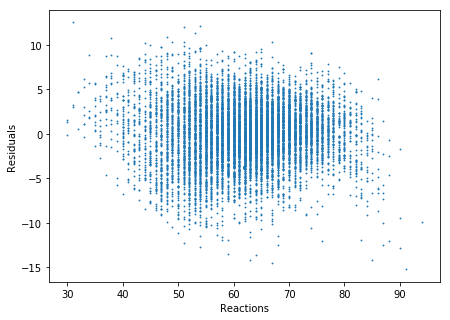

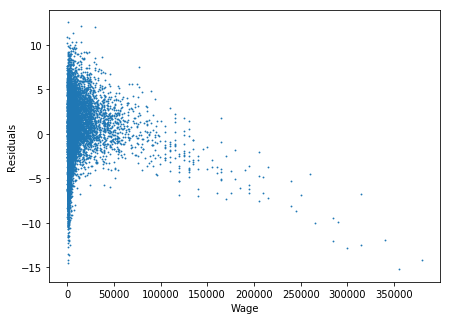

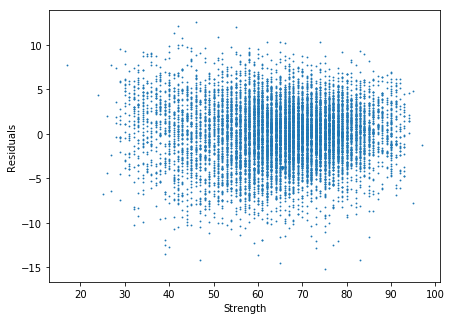

In [68]:
for i, j in enumerate(col):
    plt.figure(figsize=(7,5))
    plt.scatter(X_train[j], est2.resid, s=0.7)
    plt.xlabel(j)
    plt.ylabel('Residuals')

plt.show()


In [69]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = het_breuschpagan(est2.resid, est2.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 712.4490292571026),
 ('p-value', 4.193573320659579e-154),
 ('f-value', 253.95892102247325),
 ('f p-value', 2.5441007699095976e-159)]

f_pvalue = 0, поэтому H0(гомоскедастичность) отклоняется.

In [71]:
print('durbin_watson',durbin_watson(est2.resid))
print('nlag=2',acorr_breusch_godfrey(est2, nlags=2))
print('nlag=3',acorr_breusch_godfrey(est2, nlags=3))
print('nlag=4',acorr_breusch_godfrey(est2, nlags=4))

durbin_watson 2.000105909680496
nlag=2 (0.01090680267067512, 0.9945614414642198, 0.005450411500411986, 0.9945644177491747)
nlag=3 (2.476337145319774, 0.4795826735919205, 0.8251038179289449, 0.479799831236568)
nlag=4 (2.7335894413115676, 0.6033498190200667, 0.6830678151139533, 0.6035954511757216)


durbin_watson ~2, следовательно, нет автокорреляциии

In [72]:
kstest(est2.resid, 'norm')

KstestResult(statistic=0.25736378841077046, pvalue=0.0)

In [83]:
stat, p = shapiro(est2.resid)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.996, p=0.000
Sample does not look Gaussian (reject H0)


C:\Users\Daria_Riazanova\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning:

p-value may not be accurate for N > 5000.



In [78]:
stat, p = normaltest(est2.resid)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=171.608, p=0.000
Sample does not look Gaussian (reject H0)


In [82]:
result = anderson(est2.resid)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 11.358
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


In [84]:
XX.head()

,Reactions,Wage,Strength
4543,62.0,8000,83.0
10650,54.0,5000,67.0
10985,53.0,2000,46.0
2212,70.0,18000,74.0
3750,75.0,26000,81.0


In [130]:
col=['Reactions','Wage','Strength']
XX = X_train[col]

In [93]:
XX[(XX['Reactions']<=0.6) & (XX['Wage']<=0.6) & (XX['Strength']<=0.6)].count()

Reactions    0
Wage         0
Strength     0
dtype: int64

Попытки избавиться от гетероскедастичности. Прологарифмируем факторы.

In [132]:
XX['Reactions'] = XX['Reactions'].apply(lambda x: np.log(x))

C:\Users\Daria_Riazanova\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [135]:
XX['Wage'] = XX['Wage'].apply(lambda x: np.log(x) if (x!=0) else x )

C:\Users\Daria_Riazanova\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [136]:
XX['Strength'] = XX['Strength'].apply(lambda x: np.log(x))

C:\Users\Daria_Riazanova\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [123]:
XX[(XX['Reactions']<=0.6) & (XX['Wage']<=0.6) & (XX['Strength']<=0.6)].count()
XX.isin([np.nan, np.inf, -np.inf]).all()
np.isnan(XX.values.any())

False

In [137]:
XX.describe()

,Reactions,Wage,Strength
count,10924.000000,10924.000000,10924.000000
mean,4.113570,8.163552,4.157889
std,0.151376,1.534200,0.211770
min,3.401197,0.000000,2.833213
25%,4.025352,6.907755,4.060443
50%,4.127134,8.006368,4.189655
75%,4.219508,9.104980,4.304065
max,4.543295,12.847927,4.574711


In [142]:
X2 = sm.add_constant(XX)
est = sm.OLS(np.log(Y_train), X2)
est2 = est.fit()
print(est2.summary())


                            OLS Regression Results                            
Dep. Variable:                Overall   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                 1.103e+04
Date:                Sun, 19 May 2019   Prob (F-statistic):               0.00
Time:                        13:12:44   Log-Likelihood:                 16672.
No. Observations:               10924   AIC:                        -3.334e+04
Df Residuals:                   10920   BIC:                        -3.331e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8760      0.016    116.907      0.0

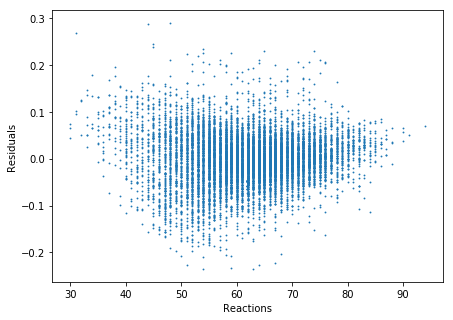

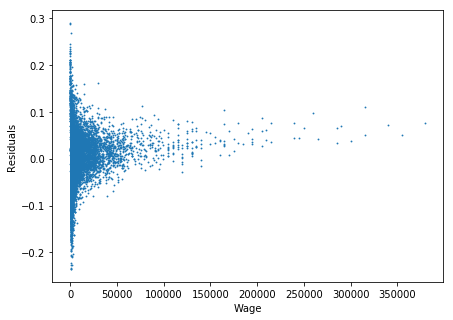

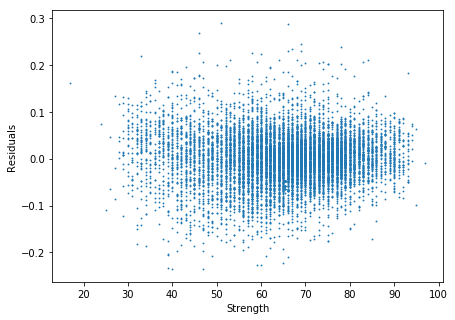

In [143]:
for i, j in enumerate(col):
    plt.figure(figsize=(7,5))
    plt.scatter(X_train[j], est2.resid, s=0.7)
    plt.xlabel(j)
    plt.ylabel('Residuals')

plt.show()


In [144]:
result = anderson(est2.resid)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))
stat, p = normaltest(est2.resid)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
stat, p = shapiro(est2.resid)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
kstest(est2.resid, 'norm')


Statistic: 42.329
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)
Statistics=431.648, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.982, p=0.000
Sample does not look Gaussian (reject H0)


C:\Users\Daria_Riazanova\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning:

p-value may not be accurate for N > 5000.



KstestResult(statistic=0.4355154416141067, pvalue=0.0)

In [145]:
col=['Reactions','Wage','Strength']
XX = X_train[col]
X2 = sm.add_constant(XX)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                Overall   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                 1.220e+04
Date:                Sun, 19 May 2019   Prob (F-statistic):               0.00
Time:                        13:44:30   Log-Likelihood:                -28591.
No. Observations:               10924   AIC:                         5.719e+04
Df Residuals:                   10920   BIC:                         5.722e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.3887      0.269    101.680      0.0

In [155]:
cols = ['Mean', 'Mean_ 1.1', 'Mean_1.2']
temp= []
dt_stat = pd.DataFrame(columns=cols)
temp= []
for name, values in XX.iteritems():
    temp.append(statistics.mean(XX[name]))
    temp.append(statistics.mean(XX[name])*1.1)
    temp.append(statistics.mean(XX[name])*1.2)
    dt_stat.loc[name] = temp
    temp=[]
    pre_dt = pre_dt+1

print(dt_stat)

                  Mean     Mean_ 1.1      Mean_1.2
Reactions    61.848035     68.032839     74.217642
Wage       9634.383010  10597.821311  11561.259612
Strength     65.279080     71.806988     78.334896


Точечный прогноз.

In [171]:
results_param = est2.params 
y_predict_1 = 1*results_param[0]+sum(results_param[1:]*dt_stat['Mean_ 1.1'])
y_predict_2 = 1*results_param[0]+sum(results_param[1:]*dt_stat['Mean_1.2'])
print('y_predict_1 ', y_predict_1)
print('y_predict_2', y_predict_2 )

y_predict_1  70.14439167988488
y_predict_2 74.03127695186201


Интервальный прогноз 

In [174]:
n = Y_pred.size-1-len(XX.columns)
t = stats.t(n)
tcr = t.ppf(1-alfa/2)
print(tcr)

1.9602899440176826


In [191]:
temp_m=np.matrix(np.matrix(XX.values).T*np.matrix(XX.values))
temp = numpy.linalg.inv(temp_m)
np.matrix(dt_stat['Mean_ 1.1'].values)
temp_q = np.matrix(dt_stat['Mean_ 1.1'].values)*temp*np.matrix(dt_stat['Mean_ 1.1'].values).T
y_predict_in = (temp_q+1)*(sum(est2.resid*est2.resid)/(Y_test.size-3-1))

# XX.Values.T*XX.Values

In [194]:
y_predict_in = math.sqrt(y_predict_in)

In [195]:
y_predict_in

4.060784320239298

In [197]:
print(y_predict_1-tcr* y_predict_in,'< y_predict1 <', y_predict_1+tcr* y_predict_in )

62.1840770120951 < y_predict1 < 78.10470634767465


In [198]:
temp_m2=np.matrix(np.matrix(XX.values).T*np.matrix(XX.values))
temp2 = numpy.linalg.inv(temp_m)
temp_q2 = np.matrix(dt_stat['Mean_1.2'].values)*temp2*np.matrix(dt_stat['Mean_1.2'].values).T
y_predict_in = (temp_q2+1)*(sum(est2.resid*est2.resid)/(Y_test.size-3-1))

In [199]:
y_predict_in = math.sqrt(y_predict_in)

In [200]:
print(y_predict_2-tcr* y_predict_in,'< y_predict2 <', y_predict_2+tcr* y_predict_in )

66.07087965510566 < y_predict2 < 81.99167424861837
